In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.utils import plot_model

/Users/ingaglotzbach/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
split_time = 3000
window_size = 60  # Number of slices to create from the time series
batch_size = 32
shuffle_buffer_size = 1000
forecast_period = 30  # For splitting data in many-to-many sequence model

In [3]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)


def plot_loss(history):
    loss=history.history['loss']
    epochs=range(len(loss)) # Get number of epochs
    plt.plot(epochs, loss, 'r')
    plt.title('Training loss')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend(["Loss"])

In [5]:
df = pd.read_csv('Sunspots.csv', usecols=['Date', 'Monthly Mean Total Sunspot Number'])

In [6]:
time = np.array(list(df.index))
sunspots = list(df['Monthly Mean Total Sunspot Number'])
series = np.array(sunspots)

time_train = time[:split_time]
train = series[:split_time]
time_test = time[split_time:]
test = series[split_time:]

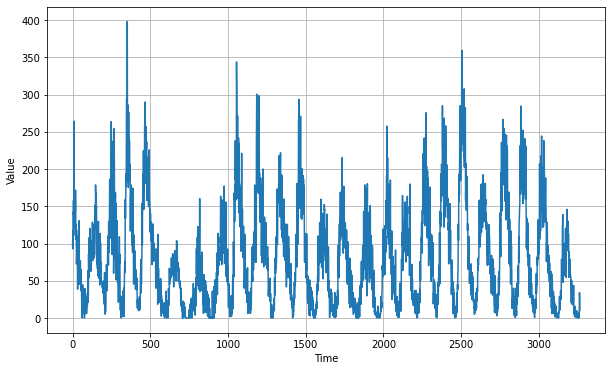

In [7]:
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [8]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    """ Helper function that turns data into a window dataset"""
    series = tf.expand_dims(series, axis=-1)  # Expand dimensions
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)  # Split a single time series to "window_size" slices with a time shift of 1, drops remainder of each slice to ensure uniform size across all slices.
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.map(lambda w: (w[:-1], w[-1:]))  # Data into features (x) and label (y)
    ds = ds.shuffle(shuffle_buffer)  # shuffle_buffer = number of data items
    ds = ds.batch(batch_size).prefetch(1)  # Batching the dataset into a groups of "batch_size"
    return ds

In [9]:
def model_forecast(model, series, window_size, batch_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)  # Split a single time series to "window_size" slices with a time shift of 1, drops remainder of each slice to ensure uniform size across all slices.
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(batch_size).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [10]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(train, window_size=window_size,
                             batch_size=batch_size, shuffle_buffer=shuffle_buffer_size)
model_many_to_one = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                         strides=1, padding="causal",
                         activation="relu",
                         input_shape=[None, 1]),  # None = Model can take sequences of any length
  tf.keras.layers.LSTM(60, activation="tanh", return_sequences=True),
  tf.keras.layers.LSTM(60, activation="tanh", return_sequences=False),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100)  # LSTM's tanh activation returns between -1 and 1. Scaling output to same range of values helps learning.
])

# Note: to turn this into a classification task, just add a sigmoid function after the last Dense layer and remove Lambda layer.

optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model_many_to_one.compile(loss=tf.keras.losses.Huber(), # Huber is less sensitive to outliers
                          optimizer=optimizer,
                          metrics=["mae"])
model_many_to_one.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, None, 60)          360       
                                                                 
 lstm (LSTM)                 (None, None, 60)          29040     
                                                                 
 lstm_1 (LSTM)               (None, 60)                29040     
                                                                 
 dense (Dense)               (None, 30)                1830      
                                                                 
 dense_1 (Dense)             (None, 10)                310       
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
 lambda (Lambda)             (None, 1)                 0

/Users/ingaglotzbach/opt/anaconda3/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/10
92/92 [==============================] - 7s 35ms/step - loss: 44.2079 - mae: 44.7040
Epoch 2/10
92/92 [==============================] - 3s 36ms/step - loss: 22.9445 - mae: 23.4380
Epoch 3/10
92/92 [==============================] - 4s 43ms/step - loss: 20.5951 - mae: 21.0876
Epoch 4/10
92/92 [==============================] - 4s 45ms/step - loss: 20.6236 - mae: 21.1153
Epoch 5/10
92/92 [==============================] - 4s 47ms/step - loss: 21.6342 - mae: 22.1285
Epoch 6/10
92/92 [==============================] - 5s 57ms/step - loss: 19.6706 - mae: 20.1635
Epoch 7/10
92/92 [==============================] - 5s 57ms/step - loss: 20.1119 - mae: 20.6053
Epoch 8/10
92/92 [==============================] - 4s 44ms/step - loss: 19.0848 - mae: 19.5781
Epoch 9/10
92/92 [==============================] - 5s 48ms/step - loss: 18.7407 - mae: 19.2332
Epoch 10/10
92/92 [==============================] - 5s 52ms/step - loss: 18.3370 - mae: 18.8289


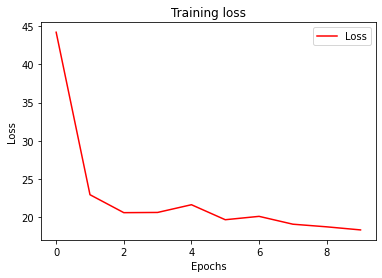

In [11]:
history = model_many_to_one.fit(train_set,epochs=10)
plot_loss(history)